In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [32]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
tf.__version__

In [ ]:
keras.__version__

In [ ]:
class_names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [33]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Pixel intensitie
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

X_train = X_train_full[5000:] 
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000] 
y_valid = y_train_full[:5000]

In [ ]:
X_train_full.shape

In [ ]:
y_valid[0]

# Pixel scaling

In [34]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True) +1e-7
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds



In [ ]:
y_train[0]

# Baseline model

On reprend l'architecture VGG pour notre modele de base, puis on rajoutera des blocks de convolution.

Base1: 1 block conv 

early_stopping:24, Overfitting after the fifth epoch. (val_loss increasing when loss decreasing) **epoch 5:** acc: 0.77, val_acc: 0.69, acc_test: 0.68

**----------------------------------------**

Base2: 2 blocks conv

early_stopping:27, Overfitting after the seventh epoch. **epoch 7:** acc: 0.83 val_acc: 0.735, acc_test: 0.726 


**----------------------------------------**

On observe que le modele avec deux blocks est plus performant que le premier.

Base3: 3 blocks conv

early_stopping:27, Overfitting after the seventh epoch. **epoch 7:** acc: 0.81, val_acc: 0.75, acc_test: 0.74 

Conclusion: Plus le modele devient profond, plus il devient performant. (tester si cette tendance s'applique avec plus de blocks)
Les 3 modeles overfit à partir d'un certain nombre d'epochs.

Comment améliorer les performances du modeles:

- Dropout
- BatchNormalization
- Alternate learning rates, adaptative learning rates, learning rate schedule
- Data Augmentation
- Transfer Learning (voir partie 2)

In [47]:
model = keras.models.Sequential([
    keras.layers.Conv2D(64, 3, padding="same",input_shape=[32, 32, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(64, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.2),
    
    keras.layers.Conv2D(128, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(128, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.3),
    
    keras.layers.Conv2D(256, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Conv2D(256, 3, padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(128),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_base3_augmentation_dropout_bn.h5", save_best_only=True)
#run_index = 4 # increment every time you train the model
#run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
#tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb]
optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.9)
optimizer1=keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer1, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [36]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_30 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_30 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_31 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 32)       

# Dropout
patience = 10

Fixed Dropout (0.2): 

acc: 0.88 - val_acc: 0.825 - acc_test: 0.82

Fixed Dropout(0.2, 0.5 fully connected layer): 

acc: 0.93 - val_acc: 0.85 - acc_test: 0.84

Increasing dropout (0.2 to 0.5):

acc: 0.8961 - val_acc: 0.8592 - acc_test: 0.843


# Data Augmentation
Dropout + Data Augmentation
 acc: 0.8224 - val_acc: 0.8646 - acc_test: 0.852

In [45]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_scaled)

# Batch Normalization
Dropout + DA + BN : acc: 0.9177 - val_acc: 0.9168 - acc_test: 0.9046

# Training model

In [48]:
# train with image augmentation
history_aug=model.fit_generator(datagen.flow(X_train_scaled, y_train, batch_size=64),
                    steps_per_epoch= len(X_train_scaled) / 64, epochs=100, validation_data=(X_valid_scaled, y_valid), callbacks = [early_stopping_cb, model_checkpoint_cb])

Train for 703.125 steps, validate on 5000 samples
Epoch 1/100
704/703 [==============================] - 29s 42ms/step - loss: 1.5508 - accuracy: 0.4468 - val_loss: 1.3395 - val_accuracy: 0.5348
Epoch 2/100
704/703 [==============================] - 25s 36ms/step - loss: 1.1010 - accuracy: 0.6127 - val_loss: 0.9709 - val_accuracy: 0.6688
Epoch 3/100
704/703 [==============================] - 26s 37ms/step - loss: 0.9397 - accuracy: 0.6724 - val_loss: 0.8001 - val_accuracy: 0.7158
Epoch 4/100
704/703 [==============================] - 26s 36ms/step - loss: 0.8550 - accuracy: 0.7035 - val_loss: 0.7590 - val_accuracy: 0.7362
Epoch 5/100
704/703 [==============================] - 26s 38ms/step - loss: 0.7863 - accuracy: 0.7303 - val_loss: 0.7051 - val_accuracy: 0.7568
Epoch 6/100
704/703 [==============================] - 26s 37ms/step - loss: 0.7349 - accuracy: 0.7486 - val_loss: 0.6141 - val_accuracy: 0.7928
Epoch 7/100
704/703 [==============================] - 26s 37ms/step - loss: 0.6

Epoch 57/100
704/703 [==============================] - 26s 37ms/step - loss: 0.2388 - accuracy: 0.9180 - val_loss: 0.3599 - val_accuracy: 0.8944
Epoch 58/100
704/703 [==============================] - 27s 38ms/step - loss: 0.2394 - accuracy: 0.9177 - val_loss: 0.2557 - val_accuracy: 0.9168
Epoch 59/100
704/703 [==============================] - 26s 37ms/step - loss: 0.2297 - accuracy: 0.9218 - val_loss: 0.3110 - val_accuracy: 0.9026
Epoch 60/100
704/703 [==============================] - 26s 37ms/step - loss: 0.2327 - accuracy: 0.9176 - val_loss: 0.2870 - val_accuracy: 0.9072
Epoch 61/100
704/703 [==============================] - 26s 37ms/step - loss: 0.2283 - accuracy: 0.9213 - val_loss: 0.3499 - val_accuracy: 0.8914
Epoch 62/100
704/703 [==============================] - 26s 37ms/step - loss: 0.2265 - accuracy: 0.9217 - val_loss: 0.3066 - val_accuracy: 0.9048
Epoch 63/100
704/703 [==============================] - 27s 39ms/step - loss: 0.2205 - accuracy: 0.9225 - val_loss: 0.2791 -

In [49]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 2s 163us/sample - loss: 0.3061 - accuracy: 0.9046


[0.3061154825091362, 0.9046]

In [53]:
from matplotlib import pyplot
# plot diagnostic learning curves
def summarize_diagnostics(history):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')

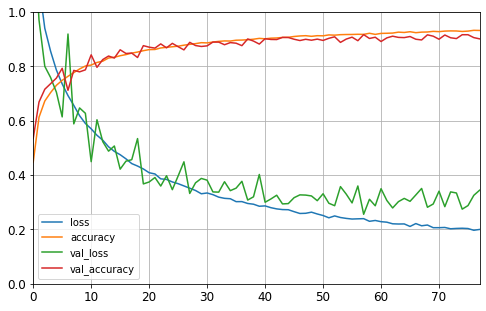

In [51]:
pd.DataFrame(history_aug.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

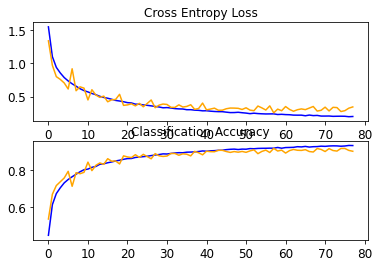

In [54]:
summarize_diagnostics(history_aug)

In [ ]:
#history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), callbacks=callbacks, epochs=100)

In [ ]:
#model.evaluate(X_test_scaled, y_test)

In [ ]:
#pd.DataFrame(history.history).plot(figsize=(8, 5))
#plt.grid(True)
#plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
#plt.show()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs --port=6006

In [ ]:
history.params

In [ ]:
%tensorboard --logdir "my_cifar10_logs"

In [55]:
pip install tensorflow_datasets 

     |████████████████████████████████| 3.3 MB 8.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Transfer Learning: Using Pretrained models from Keras (Ne pas lancer les cellules en dessous, lancer directement à partir de pip install tensorflow_datasets)

In [56]:
import tensorflow_datasets as tfds
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102973440/102967424 [==============================] - 4s 0us/step


## Resize image to ensure 224*224 for resnet

In [ ]:
class_names=["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

# Pixel intensitie
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0

X_train = X_train_full[5000:] 
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000] 
y_valid = y_train_full[:5000]

In [ ]:
images_resized = tf.image.resize(images, [224, 224])

In [ ]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)

In [ ]:
Y_proba = model.predict(inputs)

In [ ]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
for class_id, name, y_proba in top_K[image_index]:
    print(" {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
print()

In [ ]:
Comment faire si l'on veut utiliser ce classifieur si des catégories d'images (celles de notre dataset par exemple) ne sont pas incluses dans ImageNet
C'est la qu'intervient l'idée du transfer learning

In [ ]:
batch_size, height, width, channels = images.shape

In [ ]:
pip install tensorflow_datasets

In [ ]:
import tensorflow_datasets as tfds

In [ ]:

dataset, info = tfds.load("cifar10", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples # 3670
class_names = info.features["label"].names # ["airplane", "automobile", ...]
n_classes = info.features["label"].num_classes # 9

In [ ]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "cifar10",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)



In [ ]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

In [ ]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.Xception.preprocess_input(resized_image)
    return final_image, label

In [ ]:
from functools import partial

def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [ ]:
base_model_xception = keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=[224, 224, 3])

In [ ]:
base_model_xception.summary()

In [ ]:
avg = keras.layers.GlobalAveragePooling2D()(base_model_xception.output)
output = keras.layers.Dense(10, activation="softmax")(avg)
model_xception = keras.models.Model(inputs=base_model_xception.input, outputs=output)

In [ ]:
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("freeze_xception_cifar10.h5", save_best_only=True)
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model_xception.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_xception.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5,
                    callbacks=[model_checkpoint_cb])

In [ ]:
model_xception.evaluate(test_set)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
test = keras.applications.xception.Xception(weights="imagenet")

In [ ]:
test.summary()

# Layers unfreeze v1

In [ ]:
for index, layer in enumerate(base_model_xception.layers):
    print(index, layer.name)

Apres avoir entrainé le modele sur quelques epochs, on obtient de bons résultats sur le jeu de validation ainsi que le jeu de test (94% d'acc). Ce qui veut dire que les top layers sont plutot bien réglés, on est donc pret à unfreeze les toutes les couches ou, d'unfreeze les dernieres couches de base_model_xception (ce qui est plus recommandé). 
Etant donné que ce sont des blocks de convolution on unfreeze les deux derniers blocs.

On recupere l'indice du block 13.
Cette fois ci on utilise un lr beaucoup plus petit pour éviter le "damaging" sur les couches pré-entrainées.

In [ ]:
fine_tune = 116
for layer in base_model_xception.layers[fine_tune:]:
    layer.trainable = True

In [ ]:
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("unfreeze_v1_xception_cifar10.h5", save_best_only=True)
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model_xception.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_xception.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10,
                    callbacks=[model_checkpoint_cb])

In [ ]:
model_xception.evaluate(test_set)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model_xception = keras.models.load_model('unfreeze_v1_xception_cifar10.h5')

# Layers unfreeze v2.

Que se passe t-il si nous autorisons le modele à mettre à jour tous les poids de toutes les couches.....

In [ ]:
for layer in base_model_xception.layers:
    layer.trainable = True

In [ ]:
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("unfreeze_v2_xception_cifar10.h5", save_best_only=True)
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model_xception.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_xception.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10,
                    callbacks=[model_checkpoint_cb])

In [ ]:
model_xception.evaluate(test_set)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Au fur à mesure que l'on autorise le modele à mettre à jour les poids des couches, l'accuracy s'améliore. 

Notre modele va donc s'adapter à notre dataset et va se spécialiser dans la détection de features propres à celui-ci. 

Le problème c'est que l'on perd en généralisation (ce que nous offrait le modele de base avec les couches gelées) ce qui est rarement le but souhaité.

# Rajout dans l'output

In [ ]:
base_model_xception = keras.applications.xception.Xception(weights="imagenet", include_top=False, input_shape=[224, 224, 3])
avg = keras.layers.GlobalAveragePooling2D()(base_model_xception.output)
x = keras.layers.Flatten()(avg)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
output = keras.layers.Dense(10, activation="softmax")(x)
model = keras.models.Model(inputs=base_model_xception.input, outputs=output)

In [ ]:
model.summary()

In [ ]:
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("opti_xception_cifar10.h5", save_best_only=True)
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model_xception.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_xception.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5,
                    callbacks=[model_checkpoint_cb])

In [ ]:
model_xception.evaluate(test_set)

In [ ]:
fine_tune = 116
for layer in base_model_xception.layers[fine_tune:]:
    layer.trainable = True

In [ ]:
#early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("opti_unfreeze_xception_cifar10.h5", save_best_only=True)
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model_xception.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model_xception.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10,
                    callbacks=[model_checkpoint_cb])

In [ ]:
base_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(10, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

..

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# summarize filters in each convolutional layer
from matplotlib import pyplot

# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
# retrieve weights from the second hidden layer
filters, biases = model.layers[1].get_weights()
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 6, 1
pyplot.figure(figsize=(12, 12))
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
# show the figure

pyplot.show()

In [ ]:
# summarize feature map shapes
for i in range(len(model.layers)):
    layer = model.layers[i]
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # summarize output shape
    print(i, layer.name, layer.output.shape)

In [ ]:
# load the model
base_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)

# redefine model to output right after the first hidden layer
model = keras.models.Model(inputs=base_model.input, outputs=base_model.layers[1].output)
feature_maps = model.predict(test_set.take(1))
# plot all 64 maps in an 8x8 squares
square = 8
ix = 1
pyplot.figure(figsize=(12, 12))
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure

pyplot.show()

In [ ]:
model.summary()

In [ ]:
# load the model
base_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [base_model.layers[i].output for i in ixs]
model = keras.models.Model(inputs=base_model.input, outputs=outputs)

feature_maps = model.predict(test_set.take(1))
# plot the output from each block
square = 8

for fmap in feature_maps:
    pyplot.figure(figsize=(12, 12))
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

In [ ]:
base_model = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()#(base_model.output)
output = keras.layers.Dense(10, activation="softmax")#(avg)
#model = keras.models.Model(inputs=base_model.input, outputs=output)

In [ ]:
model = tf.keras.Sequential([
  base_model,
  avg,
  output
])

In [ ]:
#for layer in base_model.layers:
#    layer.trainable = True
    

base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable =  False

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=20)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

In [ ]:

# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [base_model.layers[i].output for i in ixs]
model = keras.models.Model(inputs=base_model.input, outputs=outputs)

feature_maps = model.predict(test_set.take(1))
# plot the output from each block
square = 8

for fmap in feature_maps:
    pyplot.figure(figsize=(12, 12))
    # plot all 64 maps in an 8x8 squares
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    # show the figure
    pyplot.show()

## unfreeze x layer

In [ ]:
for layer in base_model.layers:
    layer.trainable = True
    

#base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
#fine_tune_at = 10

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
#    layer.trainable =  False

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=10)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# summarize filters in each convolutional layer
from keras.applications.xception import Xception
from matplotlib import pyplot


In [ ]:
# summarize filters in each convolutional layer
from keras.applications.vgg16 import VGG16
from matplotlib import pyplot
# load the model
model = VGG16()
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue

    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

## FIN CIFAR10

## Dataset Xray

In [ ]:
classifier = keras.models.Sequential([
    keras.layers.Conv2D(64, 7, activation="relu", padding="same",
                    input_shape=[64, 64, 3]),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation="sigmoid")
])

classifier.compile(optimizer="nadam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
from pathlib import Path
# Define path to the data directory
data_dir = Path('../input/chest-xray-pneumonia/chest_xray/chest_xray')

# Path to train directory (Fancy pathlib...no more os.path!!)
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [ ]:
# Entrainer le CNN sur nos images
# Image augmentation: préparation de nos images pour éviter le surapprentissage
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=32,
        color_mode='rgb',
        classes=None,
        class_mode='binary',
        subset="training")

validation_set = train_datagen.flow_from_directory(
        train_dir,
        target_size=(64, 64),
        batch_size=32,
        color_mode='rgb',
        classes=None,
        class_mode='binary',
        subset="validation")

test_set = test_datagen.flow_from_directory(
        test_dir,
        target_size=(64, 64),
        batch_size=1,
        color_mode='rgb',
        classes=None,
        shuffle=False,
        class_mode='binary')

In [ ]:
history = classifier.fit_generator(
        training_set,
        steps_per_epoch=131,
        epochs=30,
        validation_data=validation_set,
        validation_steps=33,
        verbose=1)

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
STEP_SIZE_TEST=test_set.n//test_set.batch_size
classifier.evaluate_generator(generator=test_set,
steps=STEP_SIZE_TEST)

In [ ]:
STEP_SIZE_VAL=validation_set.n//validation_set.batch_size
classifier.evaluate_generator(generator=validation_set,
steps=STEP_SIZE_VAL)

# Analyse sur jeu de validation

In [ ]:
STEP_SIZE_VAL=validation_set.n//validation_set.batch_size
validation_set.reset()
pred=classifier.predict_generator(validation_set,
steps=STEP_SIZE_VAL,
verbose=1)

In [ ]:
for p in pred:
    print(p)

In [ ]:
predictions = (pred > 0.5).astype(np.int)


In [ ]:
predictions=predictions.reshape(624,)

In [ ]:
labels = (validation_set.labels)

In [ ]:
filenames=validation_set.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions,
                      "True": validation_set.labels
                     })

In [ ]:
results

In [ ]:
err = results.loc[results['Predictions'] != results['True']]
err